In [1]:
# SpnAsp experiment test notebook

In [3]:
import time
import sys
#sys.path.append('../../')
sys.path.append('../')
sys.path.append('../SpnAsp/')
sys.path.append('../EinsumNetwork/')
sys.path.append('../SlotAttentionObjDiscovery/')


#torch, numpy, ...
import torch
from torch.utils.tensorboard import SummaryWriter
torch.cuda.empty_cache()

import numpy as np
import importlib
import matplotlib.pyplot as plt

plt.style.use(["science", "grid"])  # Need SciencePlots pip package

import matplotlib
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": False,
    }
)


import utils


from spnasp import SpnASP
from dataGen import get_loader, get_data_and_object_list, CLEVR
from tqdm.notebook import tqdm

from network import Net
from slot_attention import SlotAttention_model
import slot_attention_obj_discovery as obj_discovery



A detection is considered a **true positive** if the discrete predicted properties (obtained with an argmax) exactly match the ground truth. 
- This excludes predicting the correct background object
- If we predict two blue spheres but only have one blue sphere as our ground truth we get one true positve and one false positve

A detection is considered a **false positive** if the discrete predicted properties (obtained with an argmax) do not exactly match the ground truth.
- If we predict an object with either shape background or color black this is considered a false positive.

A detection is considered a **true negative** if the background is predicted correctly.
- We have one background prediction for each sample
- If we predict two background objects we would get one true negative and one false negative




In [3]:
#MODEL = "most_probable_with_slot_with_lr_decay"
MODEL = "most_prob_pd_endtoend"
#data/one_to_one_pretrained_test_2/spn_slot_models.pt
class_count = 4

model_path = "data/"+MODEL+"/spn_slot_models.pt" 
models = torch.load(model_path)

exp_dict = models['exp_dict']
print(exp_dict)

print(models.keys())
program = models['program']

if exp_dict['structure'] == 'poon-domingos':
    print("using poon-domingos")

    #color network
    c_net = Net(structure = exp_dict['structure'],
        pd_num_pieces = exp_dict['pd_num_pieces'],
        num_var = 32,
        class_count=4,
        use_em= exp_dict['use_em'])

    #shape network
    s_net = Net(structure = exp_dict['structure'],
        pd_num_pieces = exp_dict['pd_num_pieces'],
        num_var = 32,
        class_count=4,
        use_em= exp_dict['use_em'])

elif exp_dict['structure']== 'binary-trees':
    print("using binary-trees")

    c_net = Net(structure = exp_dict['structure'],
        depth = exp_dict['depth'],
        num_repetitions = exp_dict['num_repetitions'],
        num_var = 32,
        class_count=4,
        use_em= exp_dict['use_em'])

    #shape network
    s_net = Net(structure = exp_dict['structure'],
        depth = exp_dict['depth'],
        num_repetitions = exp_dict['num_repetitions'],
        num_var = 32,
        class_count=4,
        use_em= exp_dict['use_em'])

#create the Slot Attention network
slot_net = SlotAttention_model(n_slots=3, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32)).to(device='cuda')# was 32*32 and 128

slot_net_obj_discovery = obj_discovery.SlotAttention_model(n_slots=3, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32))#.to(device='cuda')# was 32*32 and 128
slot_net_obj_discovery.eval()


#load all model parts
s_net.load_state_dict(models['s_net'])
c_net.load_state_dict(models['c_net'])
slot_net.load_state_dict(models['slot_net'])


#load the pretrained model
model_path = "data/slot-attention-shapeworld2-objdiscovery-pretrain-0" #load the pretrained model
pretrained_model = torch.load(model_path)['weights']

keys = list(pretrained_model.keys())

#replace module. with withespaces
for key in keys:
    new_key = key.replace('module.','')
    #print(new_key," ", key)
    pretrained_model[new_key] = pretrained_model.pop(key)
slot_net_obj_discovery.load_state_dict(pretrained_model)



s_params = list(s_net.parameters()) + list(slot_net.parameters())
c_params = list(c_net.parameters()) + list(slot_net.parameters())


#create the SPN ASP Program
nnMapping = {'color': c_net,
             'shape':s_net}
optimizers = {'color': torch.optim.Adam(c_params, lr=exp_dict['lr'], eps=1e-7),
              'shape':torch.optim.Adam(s_params, lr=exp_dict['lr'], eps=1e-7)}
SpnASPobj = SpnASP(program, nnMapping, optimizers)

{'structure': 'poon-domingos', 'pd_num_pieces': [4], 'lr': 0.01, 'bs': 512, 'epochs': 700, 'pretrained_slot_module': False, 'debug': False, 'lr_warmup': True, 'lr_warmup_steps': 25, 'use_em': False, 'train_slot': True, 'start_date': '27-03-2021', 'explanation': 'Trying out most probable SM with LR warmup and annealing. Background labels provided. \n              The SPN size is the default one in the paper. For backpropagating the gradients i multiplied all gradients \n              with its outputs and then computed the mean over all products and the backwarded the negative of it.'}
dict_keys(['s_net', 'c_net', 'slot_net', 'test_ll_list', 'test_ap_list', 'test_metric_list', 'lr_list', 'num_params', 'time', 'exp_dict', 'program'])
using poon-domingos
train SPN with EM: False
train SPN with EM: False


In [4]:
#self.mvpp['program'], self.mvpp['program_pr'], self.mvpp['program_asp'] = self.parse(obs='')

print(SpnASPobj.mvpp['program_pr'])

print("\n\n")
print(SpnASPobj.mvpp['program_asp'])

@0.0 color(0, s1, red); @0.0 color(0, s1, blue); @0.0 color(0, s1, green); @0.0 color(0, s1, black).
@0.0 color(0, s2, red); @0.0 color(0, s2, blue); @0.0 color(0, s2, green); @0.0 color(0, s2, black).
@0.0 color(0, s3, red); @0.0 color(0, s3, blue); @0.0 color(0, s3, green); @0.0 color(0, s3, black).
@0.0 shape(0, s1, circle); @0.0 shape(0, s1, triangle); @0.0 shape(0, s1, square); @0.0 shape(0, s1, bg).
@0.0 shape(0, s2, circle); @0.0 shape(0, s2, triangle); @0.0 shape(0, s2, square); @0.0 shape(0, s2, bg).
@0.0 shape(0, s3, circle); @0.0 shape(0, s3, triangle); @0.0 shape(0, s3, square); @0.0 shape(0, s3, bg).



slot(s1).
slot(s2).
slot(s3).
name(o1).
name(o2).
name(o3).
%assign each name a slot
{slot_name_comb(N,X): slot(X) }=1 :- name(N). %problem we have dublicated slots
%remove each model which has multiple slots asigned to the same name
:-  slot_name_comb(N1,X1), slot_name_comb(N2,X2), X1 == X2, N1 != N2.
%build the object ontop of the slot assignment
object(N,C,S) :- color(0,

# Model predictions

In [4]:
dataListTrain, obsListTrain, objListTrain= get_data_and_object_list(CLEVR('../../data/CLEVR_v1.0/',"val"), 1, shuffle=True)
print(len(dataList), len(obsList))

inference, out = SpnASPobj.infer_batch(slot_net=slot_net, data_batch= dataList[5])


#test size 100
#val size 5.000
#train size 20.000

FileNotFoundError: [Errno 2] No such file or directory: '../../data/CLEVR_v1.0/images/val'

In [6]:
def interpret_inference(inference,print_obs =True):
    #circle 0, triangle 1, square 2
    #red 0, blue 1, green 2
    
    inference_list = []
    
    for slot in inference:
        shape = inference[slot]['shape']
        color = inference[slot]['color']
        sid = torch.argmax(shape)
        cid = torch.argmax(color)
        s=''
        c=''
        #print(sid, cid)
        if cid == 0:
            c= 'red'
        elif cid == 1:
            c= 'blue'
        elif cid == 2:
            c= 'green'
        elif cid == 3:
            c= 'black'
            
        if sid == 0:
            s='circle'
        elif sid == 1:
            s='triangle'
        elif sid == 2:
            s='square'
        elif sid == 3:
            s='bg'    
        
        if print_obs:
            print("there is a {} {} in the image.".format(c, s))
        
        #if c != 'black' and s != 'bg': 
        inference_list.append([c, s])
    
    return inference_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


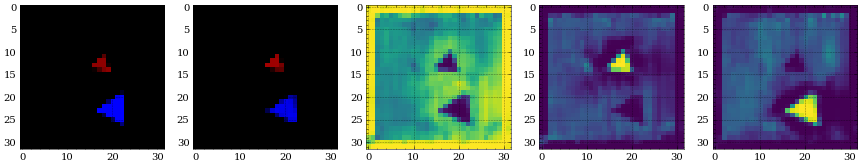

The model says:
there is a black bg in the image.
there is a red triangle in the image.
there is a blue triangle in the image.

with probabilities:
    red,   blue,  green, black, circle, triangle, square, bg
s0 [0.000, 0.000, 0.000, 1.000] [0.000, 0.000, 0.000, 1.000]
s1 [1.000, 0.000, 0.000, 0.000] [0.000, 1.000, 0.000, 0.000]
s2 [0.000, 1.000, 0.000, 0.000] [0.000, 1.000, 0.000, 0.000]

 Our GT is:
 :- not object(o1,red,triangle). :- not object(o2,blue,triangle). :- not object(o3, black, bg).


In [7]:
idx = int(np.random.rand()* len(dataList))

#forward the image through the pretrained slot masks to get a feeling how the attention binary maps look like
with torch.no_grad():
    recon_combined, recons, masks, slots  = slot_net_obj_discovery(dataList[idx]['im'])

masks = masks.squeeze() 


img = np.einsum("abc->bca",dataList[idx]['im'].cpu().numpy().squeeze())
recon_img = np.einsum("abc->bca", recon_combined.numpy().squeeze())

f, axarr = plt.subplots(1,5,figsize=(15,15))#, figsize(2,4))

axarr[0].imshow(img)
axarr[1].imshow(recon_img)
axarr[2].imshow(masks[0])
axarr[3].imshow(masks[1])
axarr[4].imshow(masks[2])
plt.show()



#get the predictions of what is in the image
inference, out = SpnASPobj.infer_batch(slot_net=slot_net, data_batch= dataList[idx])

print("The model says:")
interpret_inference(inference)



print("\nwith probabilities:")
print("    red,   blue,  green, black, circle, triangle, square, bg")
for slot in inference.keys():
    
    
    color = ("["+', '.join(['%.3f']*4)+"]") % tuple(inference[slot]['color'].cpu().numpy()[0])
    shape = ("["+', '.join(['%.3f']*4)+"]") % tuple(inference[slot]['shape'].cpu().numpy()[0])
    print(slot,color,shape)
    
 
print("\n Our GT is:\n",obsList[idx])



In [8]:
a= torch.Tensor([0,1,2])
b = torch.Tensor([0,1,2])

torch.stack((a,b))

tensor([[0., 1., 2.],
        [0., 1., 2.]])

In [9]:
idx = int(np.random.rand()* len(dataList))
dataListArray = np.array(dataList)
inference, _ = SpnASPobj.infer_batch(slot_net=slot_net, data_batch= dataListArray[:])

#iterate over all slots
#print(inference)



y = 0
x = y+100
pred = utils.inference_map_to_array(inference).cpu().numpy()
target = np.array(objList)

print(pred.shape,target.shape)

ap, true_positives,false_positives, true_negatives, correctly_classified = utils.average_precision_clevr(pred, target,-1)
print("avg precision",ap, "tp", true_positives, "fp", false_positives, "tn", true_negatives, "correctly classified", correctly_classified)

pred = utils.inference_map_to_array(inference.copy(), only_color=False).cpu().numpy()
ap, true_positives,false_positives, true_negatives, correctly_classified = utils.average_precision_clevr(pred, target,-1, only_color = True)
print("avg precision color",ap, "tp", true_positives, "fp", false_positives, "tn", true_negatives, "correctly classified", correctly_classified)



pred = utils.inference_map_to_array(inference.copy(), only_shape=False).cpu().numpy()
ap, true_positives,false_positives, true_negatives, correctly_classified = utils.average_precision_clevr(pred, target,-1, only_shape = True)
print("avg precision shape",ap, "tp", true_positives, "fp", false_positives, "tn", true_negatives, "correctly classified", correctly_classified)

(100, 3, 9) (100, 2, 9)
avg precision 0.9950000047683716 tp 199.0 fp 1.0 tn 100.0 correctly classified 99
avg precision color 1.0 tp 200.0 fp 0.0 tn 100.0 correctly classified 100
avg precision shape 0.9950000047683716 tp 199.0 fp 1.0 tn 100.0 correctly classified 99


## Log Likelihoods
circle 0, triangle 1, square 2
red 0, blue 1, green 2
            

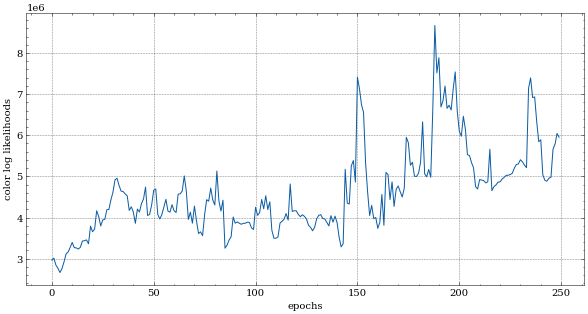

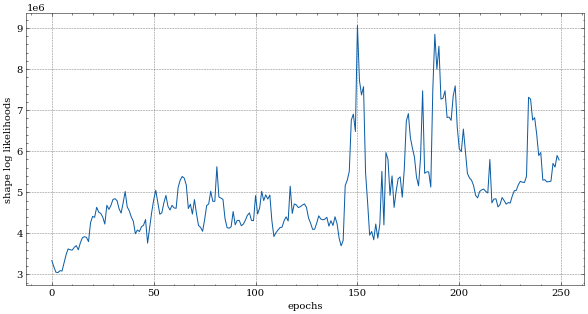

In [10]:
test_ll_list = models['test_ll_list']

temp= np.zeros((len(test_ll_list), 3))


for i, ll in enumerate(test_ll_list):
    temp[i,0] = ll[1]
    temp[i,1] = ll[0][0]
    temp[i,2] = ll[0][1]

x = temp.shape[0]
x= 250
sign = -1
if exp_dict['use_em']:
    sign = 1
    
fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,1], label="c")
plt.xlabel("epochs")
plt.ylabel("color log likelihoods")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,2])
plt.xlabel("epochs")
plt.ylabel("shape log likelihoods")
plt.show()

plt.show()



# Average Precision 

[tensor([-2963761., -3336553.]), 0]


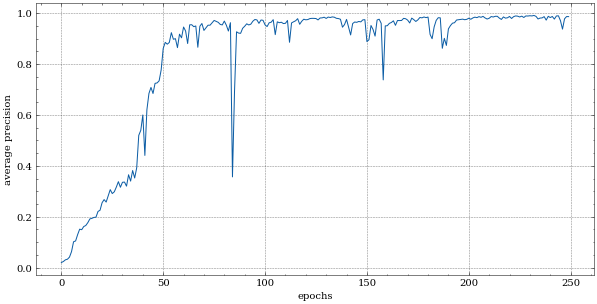

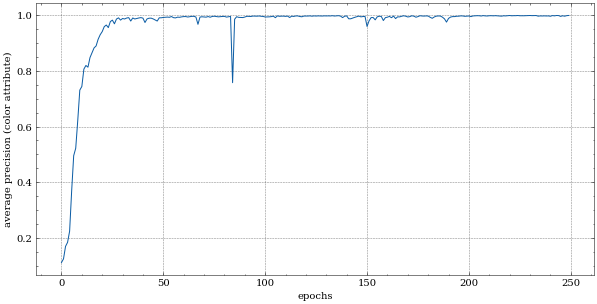

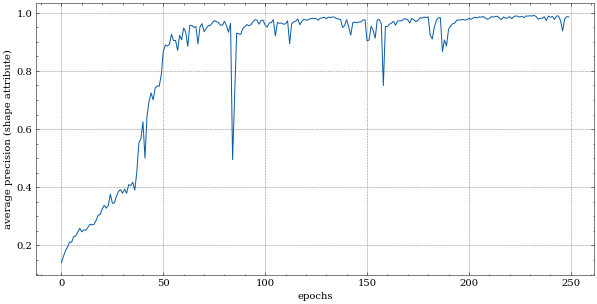

In [11]:
test_ap_list = models['test_ap_list']
test_ap_list = np.array(test_ap_list)
print(test_ll_list[0])


x = temp.shape[0]
x= 250


fig = plt.figure(figsize=(10,5))    
plt.plot(test_ap_list[:x,3], test_ap_list[:x,0], label="c")
plt.xlabel("epochs")
plt.ylabel("average precision")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(test_ap_list[:x,3], test_ap_list[:x,1], label="c")
plt.xlabel("epochs")
plt.ylabel("average precision (color attribute)")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(test_ap_list[:x,3], test_ap_list[:x,2], label="c")
plt.xlabel("epochs")
plt.ylabel("average precision (shape attribute)")
plt.show()

plt.show()



### lr rates

[[list([0.01, 1.6000000000000003e-05]) 0]
 [list([0.01, 3.2000000000000005e-05]) 1]
 [list([0.01, 4.8e-05]) 2]
 [list([0.01, 6.400000000000001e-05]) 3]
 [list([0.01, 8e-05]) 4]
 [list([0.01, 9.6e-05]) 5]
 [list([0.01, 0.00011200000000000001]) 6]
 [list([0.01, 0.00012800000000000002]) 7]
 [list([0.01, 0.000144]) 8]
 [list([0.01, 0.00016]) 9]
 [list([0.01, 0.00017600000000000002]) 10]
 [list([0.01, 0.000192]) 11]
 [list([0.01, 0.00020800000000000001]) 12]
 [list([0.01, 0.00022400000000000002]) 13]
 [list([0.01, 0.00024]) 14]
 [list([0.01, 0.00025600000000000004]) 15]
 [list([0.01, 0.00027200000000000005]) 16]
 [list([0.01, 0.000288]) 17]
 [list([0.01, 0.000304]) 18]
 [list([0.01, 0.00032]) 19]
 [list([0.01, 0.000336]) 20]
 [list([0.01, 0.00035200000000000005]) 21]
 [list([0.01, 0.00036800000000000005]) 22]
 [list([0.01, 0.000384]) 23]
 [list([0.01, 0.0004]) 24]
 [list([0.01, 0.0004]) 25]
 [list([0.01, 0.0003999981046061428]) 26]
 [list([0.01, 0.00039999241846562847]) 27]
 [list([0.01, 0.

/home/dochs/anaconda3/envs/env_dev/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


ValueError: x and y must have same first dimension, but have shapes (401,) and (2,)

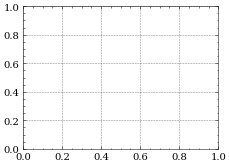

In [12]:
'''
lr_list = np.array( models['lr_list'])
epochs = lr_list[:,1]
lr=np.stack(lr_list[:,0])

plt.plot(epochs, lr_list[:,0][0])
plt.show()
plt.plot(epochs, lr_list[:,0][1])
plt.show()

'''

lr_list = np.array( models['lr_list'])
print(lr_list)
epochs = lr_list[:,1]
lr=np.stack(lr_list[:,0])

plt.plot(epochs, lr_list[:,0][0])
plt.show()
plt.plot(epochs, lr_list[:,0][1])
plt.show()

# Model comparison


(401, 4)
(386, 4)
(376, 4)
(417, 4)


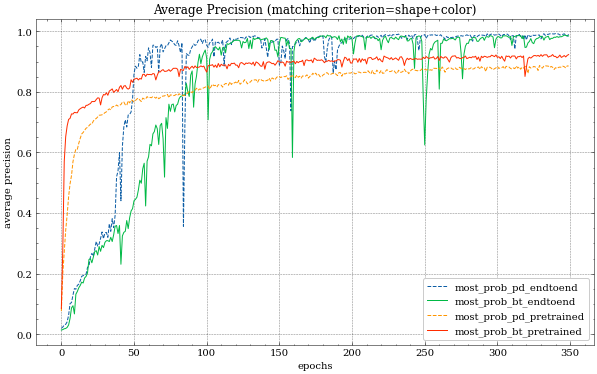

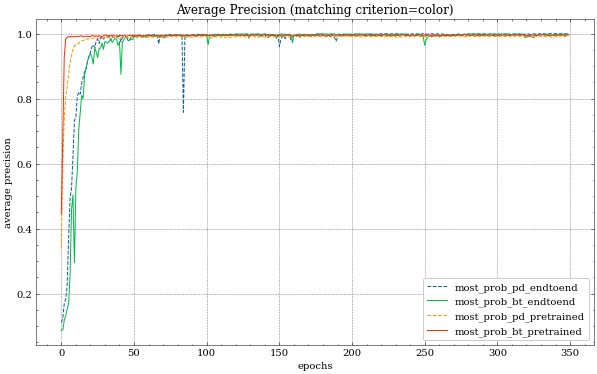

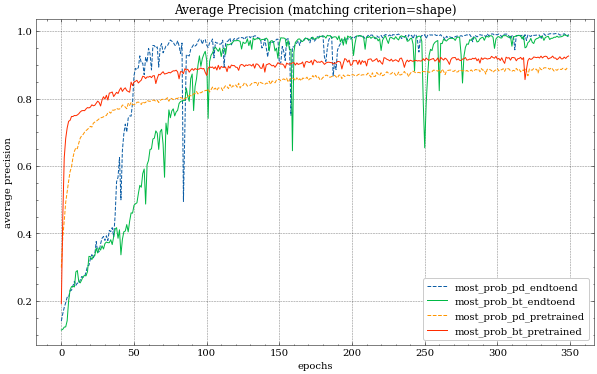

In [45]:
model_paths = ["most_prob_pd_endtoend", "most_prob_bt_endtoend", "most_prob_pd_pretrained" , "most_prob_bt_pretrained"]



fig1, ax1 = plt.subplots(figsize=(10,6))
fig2, ax2 = plt.subplots(figsize=(10,6))
fig3, ax3 = plt.subplots(figsize=(10,6))

#fig = plt.figure()  
ax1.set_title("Average Precision (matching criterion=shape+color)")
ax1.set_ylabel("average precision")
ax1.set_xlabel("epochs")
ax2.set_title("Average Precision (matching criterion=color)")
ax2.set_ylabel("average precision")
ax2.set_xlabel("epochs")
ax3.set_title("Average Precision (matching criterion=shape)")
ax3.set_ylabel("average precision")
ax3.set_xlabel("epochs")


for mp in model_paths:
    model_path = "data/"+mp+"/spn_slot_models.pt" 
    models = torch.load(model_path)

    test_ap_list = models['test_ap_list']
    test_ap_list= np.array(test_ap_list)
    
    style="-"
    if models['exp_dict']['structure'] == 'poon-domingos':
        style="--"
    print(test_ap_list.shape)
    x= 350


    ax1.plot(test_ap_list[:x,3], test_ap_list[:x,0],style, label=mp)    
    ax2.plot(test_ap_list[:x,3], test_ap_list[:x,1],style, label=mp)    
    ax3.plot(test_ap_list[:x,3], test_ap_list[:x,2],style, label=mp)    

    ax1.legend()
    ax2.legend()
    ax3.legend()
plt.show()

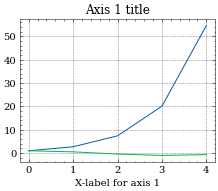

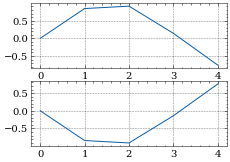

In [31]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(5)
y = np.exp(x)
fig1, ax1 = plt.subplots()
ax1.plot(x, y)
ax1.set_title("Axis 1 title")
ax1.set_xlabel("X-label for axis 1")

z = np.sin(x)
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
ax2.plot(x, z)
ax3.plot(x, -z)

w = np.cos(x)
ax1.plot(x, w) # can continue plotting on the first axis

plt.show()
